# Mathematical Modelling for Sustainable Development
## Coursework Submission 2025
### Serena Farrelly

Question 1: Healthcare Resource Allocation Modelling

Modelling a queuing system to model arriving patients (walk ins and prearranged appointments) and the allocation of four clinicians. We want to assess the efficiency of the system and identify causes of delays.


### Modelling Assumptions

- a patient with an appointment arrives every 30 minutes

In [99]:
# Python Packages
import simpy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import deque # this is a new data type that is a 'double ended queue'

In [100]:
# Class defintions
class HealthCareService_c:
    def __init__(self, env, num_clinicians):
        self.env = env
        self.clinicians = simpy.Resource(self.env, num_clinicians)
        self.patients_list = [] # empty list to be filled with Patient_c class objects
        self.num_patients = 0 # initialised at 0
        self.num_patients_seen = 0 # initialised at 0
        self.num_in_sys = [(0,0)]

        self.waits = []                                 # Creates a list to track waiting times for each customer
        self.total_wait = 0.0                           # Creares a variable for storing the total waiting time
        self.in_systems = [(0, 0)]                      # Track customers in the system with their arrival/departure times and the queue lengths
        self.queue = deque()                            # Initialises an empty queue to manage customer arrivals


        # tracking clinician up time
        self.usage_time = 0  # Total occupied time
        self.last_acquired = None  # Timestamp of last acquisition
    
    def define_param(self, mu_walkin, mu_service, duration):
        self.mu_walkin = mu_walkin #  mean walkin rate (mins)
        self.mu_service = mu_service # mean service rate (mins)
        self.duration = duration # simulation duration (mins)

    def clin_release(self, req):
        self.clinicians.release(req)
        if self.last_acquired is not None:
            self.usage_time += self.env.now - self.last_acquired  # Update occupied time
            self.last_acquired = None  # Reset

    def clin_log(self):
        self.last_acquired = self.env.now  # Log when resource is acquired
    
    def reset(self):
        self.num_patients_seen = 0
        self.num_in_sys = [(0,0)]
        self.patients_list = []


class Patient_c:
    def __init__(self, id, type, entry_time):
        self.id = id
        self.type = type
        self.entry_time = entry_time
        self.wait_time = 0
        self.service_time = 0
        self.exit_time = 9999 # arbitrary high number. Gets updated when patient exits
    
    def __str__(self):
        return f"Patient:{self.id}(Type:{self.type}, Entry Time: {self.entry_time}, Exit Time: {self.entry_time})"
    

In [101]:
# Simulation Functions

def Source_appt():
    # regular appointments through out the day
    # they arrive every 30 mins
    # a pretty hellish schedule lol
    return 30


def Source_walkin(mu_walkin):
    # random walkins
    return np.random.exponential(mu_walkin)

def Service_time(mu_service):
    # how long each appmnt takes
    return np.random.exponential(mu_service)

# Simulation function for the queuing system
def HealthCareService(env, HCS_obj, lunch_rush):
    next_patient_time = 0                                       # Intialise time variable to be minimised when the next patient time is determined
    last_patient_type = 1                                       # patient type: 1 = appointment, 2 = walkin
    next_walkin = 0

    mu_walkin = HCS_obj.mu_walkin
    while True:                                                 # In this case, while the simulation is running
        
        # vary patient arrival rate depending on simulation time
        if (env.now>=180 and env.now<=300 and lunch_rush):
            HCS_obj.mu_walkin = mu_walkin/2 # time in between arrivals is halved


        # Find out which is the next patient: walk in or appointment
        if (next_walkin==0 or last_patient_type == 2):
            # if this value is 0 (initialise) or the last patient was a walkin
            # generate a new talk in time
            next_walkin = Source_walkin(HCS_obj.mu_walkin)
        
        # compare which is the next patient: appointment or walkin
        if (next_walkin < Source_appt()):
            last_patient_type = 2
            next_patient_time = next_walkin
        else:
            last_patient_type = 1
            next_patient_time = Source_appt()
        
        # creating a object in the Patient_c class and appending to patient list
        HCS_obj.num_patients += 1
        Patient_i = Patient_c(HCS_obj.num_patients,last_patient_type,0)
        
        # this is essentially a delay simulation until next patient arrival
        yield env.timeout(next_patient_time)

        # When the patient arrives, start a new patient process
        env.process(Patient(env, HCS_obj, Patient_i))

        # append serviced patient to patient list (all info stored within)
        HCS_obj.patients_list.insert(-1,Patient_i)

# patient process function to simulate each patient's interaction with the server
def Patient(env, HCS_obj, patient_obj):
    patient_obj.entry_time = env.now
    # Request a server from the pool of available servers
    # we are waiting for a clinician to be available
    with HCS_obj.clinicians.request() as request:
        # t_arrival = env.now  # Capture the arrival time of the patient

        # Track the number of patients currently in the system (both in service and in queue)
        HCS_obj.num_in_sys.append((patient_obj.entry_time, len(HCS_obj.clinicians.queue) + len(HCS_obj.clinicians.users)))
        # Log the patient arrival, including the number of patients 
        # print(f'{env.now}: patient {patient} arrives.  Current number of people in the system: {len(servers.queue) + len(servers.users)}')       

        # Yield until the patient gets service (i.e., waits for a server to be available)
        yield request

        HCS_obj.clin_log() # log if the patient has been picked up by a clinician

        # Generate and wait for the service time (time spent being served)
        patient_obj.service_time = Service_time(HCS_obj.mu_service)
        yield env.timeout(patient_obj.service_time)

        HCS_obj.clin_release(request) # log that the clinicians is now relieved of duty

        # patient departs after service
        patient_obj.exit_time = env.now  # Capture the departure time of the patient

        # Track the number of patients in the system after this patient departs
        HCS_obj.num_in_sys.append((patient_obj.exit_time, len(HCS_obj.clinicians.queue) + len(HCS_obj.clinicians.users)))

        # Log the patient departure, including the number of patients
        # print(f'{env.now}: patient {patient} departs. Current number of people in the system: {len(servers.queue) + len(servers.users) - 1}')

        # Record the wait time and service time for the patient
        patient_obj.wait_time = env.now - patient_obj.entry_time - patient_obj.service_time

        HCS_obj.num_patients_seen += 1




In [102]:
# whether we want to model the lunch rush
lunch_rush = True

# Create parameter sweep
n_intvl = 10
arrival_rates = np.linspace(5,30,n_intvl) # i
service_rates = np.linspace(5,30,n_intvl) # j
sim_duration = 60*8
# print(arrival_rates)

# want to repeat to get confidence intervals
n_rep = 20 # r

simulation_results = np.empty((n_intvl, n_intvl, n_rep), dtype=object)

# loop to create simulation class objects
for i in range(n_intvl):
    for j in range(n_intvl):
        for r in range(n_rep):
            env = simpy.Environment()
            #initialise simulation class object
            HealthCareSim = HealthCareService_c(env, 4)
            HealthCareSim.define_param(mu_walkin=arrival_rates[i], mu_service=service_rates[j],duration=sim_duration)

            # clear data from last run
            HealthCareSim.reset()

            #run simulation
            env.process(HealthCareService(HealthCareSim.env, HealthCareSim, lunch_rush))
            env.run(until=HealthCareSim.duration)
            # save all results
            simulation_results[i, j, r] = HealthCareSim

# print(simulation_results[0:4,:,:])

### Yippee post processing

In [ ]:
# KPIs
# average wait time
# number of patients seen
# clinician up time

avg_wait = num_patients = clin_up = wait_60 = np.zeros((n_intvl, n_intvl, n_rep))

for i in range(n_intvl):
    for j in range(n_intvl):
        for r in range(n_rep):
            patient_waits = [patient.wait_time for patient in simulation_results[i, j, r].patients_list]
            avg_wait[i,j,r] = np.mean(patient_waits)
            wait_60[i,j,r] = sum(x > 60 for x in patient_waits)

            num_patients[i, j, r] = len(patient_waits)

            clin_up[i, j, r] = simulation_results[i, j, r].usage_time

### Plotting

In [104]:
font_size = 22
tick_size = 16
label_padding = 25

(10, 10)
[[110.23815496 128.64044921 153.17719929 229.17731975 271.99982456
  362.62200933 417.85096537 417.25060881 436.33356842 446.76282619]
 [ 83.93830122 118.18598964 124.00632254 152.67827115 140.05729175
  156.96799527 181.80308936 236.24330843 178.02123699 193.46135568]
 [ 76.53225126 122.86889051 135.27935061 133.877978   128.3046606
  132.97682111 135.83465475 144.41852885 148.90293119 150.91411467]]
69.20240754009572


/tmp/ipykernel_452334/1266200387.py:31: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


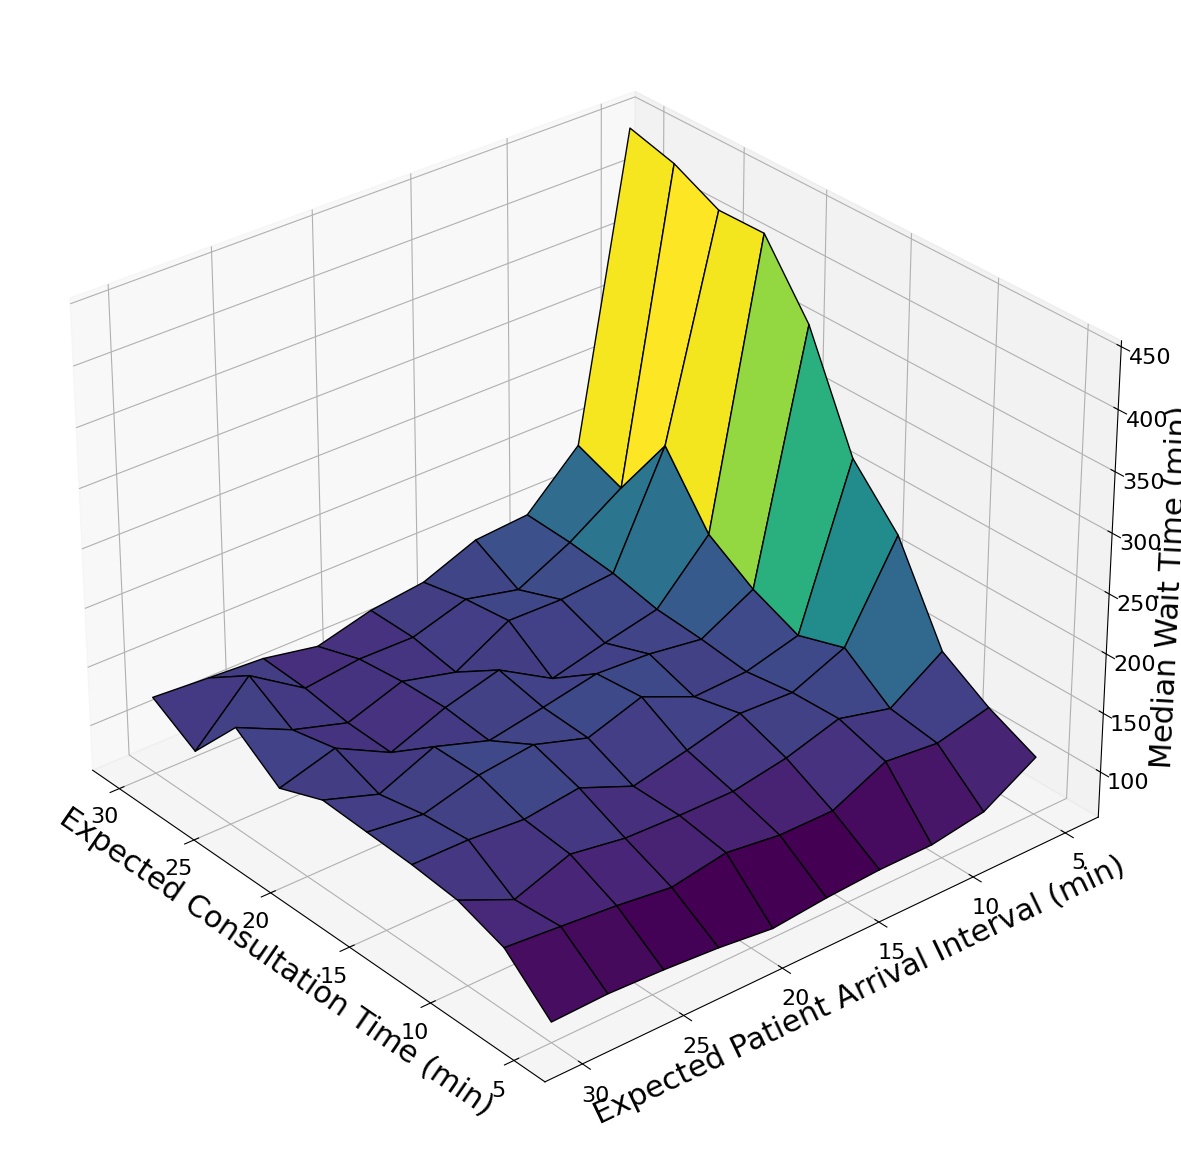

In [114]:
# average wait time (surface plot)
X, Y = np.meshgrid(service_rates, arrival_rates)

median_avg_wait = np.median(avg_wait, axis=2)
print(np.shape(median_avg_wait))
print(median_avg_wait[0:3])
print(np.min(median_avg_wait))

# Plot surface
fig = plt.figure(figsize=(12, 16))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, median_avg_wait, cmap='viridis', edgecolor='k')
ax.view_init(elev=30, azim=140)
ax.dist = 50

ax.set_xlabel("Expected Consultation Time (min)", fontdict={'fontsize':font_size})
ax.set_ylabel("Expected Patient Arrival Interval (min)", fontdict={'fontsize':font_size})
ax.set_zlabel("Median Wait Time (min)", fontdict={'fontsize':font_size})

# ax.xaxis.labelpad = label_padding  
# ax.yaxis.labelpad = label_padding  
# ax.zaxis.labelpad = label_padding

pos = ax.get_position()  # Get current plot position
ax.set_position([pos.x0 - 1, pos.y0, pos.width, pos.height])  # Shift left


ax.tick_params(axis="both", labelsize=tick_size)

plt.tight_layout()
plt.subplots_adjust(left=0.005, right=0.95) 
plt.show()


(10, 10)
[[28.06246005 42.39885436 60.15067537 70.19851762 77.81925241 80.12932602
  82.26701959 84.74797479 88.25365206 87.64497887]
 [13.2033325  15.61179836 22.26170216 20.85133616 36.38358522 40.35806231
  42.33524391 28.13452963 43.14384433 46.13519184]
 [ 8.11057979 10.10435045 12.43638802 13.50895473 14.09007921 16.50019889
  15.78594167 13.07411288 17.68099446 15.81972406]]


/tmp/ipykernel_452334/623200507.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


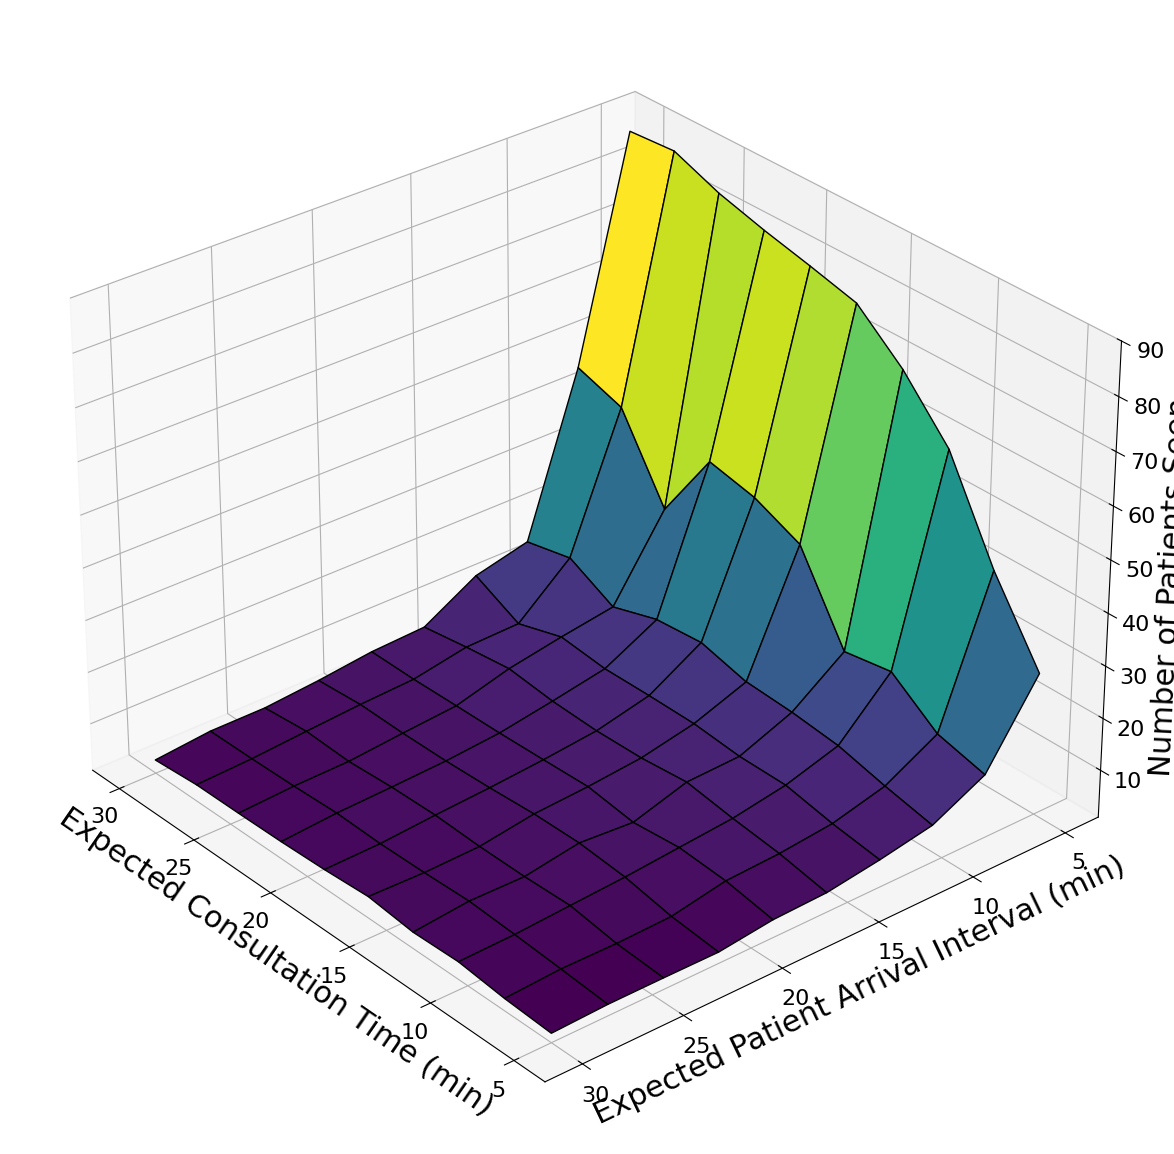

In [106]:
# average wait time (surface plot)
X, Y = np.meshgrid(service_rates, arrival_rates)


median_num_patients = np.zeros_like(median_avg_wait)
print(np.shape(median_num_patients))
# use little law
for i in range(n_intvl):
    for j in range(n_intvl):
        median_num_patients[i,j] = median_avg_wait[i,j]*(1/arrival_rates[i])
print(median_num_patients[0:3])

# Plot surface
fig = plt.figure(figsize=(12, 16))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, median_num_patients, cmap='viridis', edgecolor='k')
ax.view_init(elev=30, azim=140)
ax.dist = 50

ax.set_xlabel("Expected Consultation Time (min)", fontdict={'fontsize':font_size})
ax.set_ylabel("Expected Patient Arrival Interval (min)", fontdict={'fontsize':font_size})
ax.set_zlabel("Number of Patients Seen", fontdict={'fontsize':font_size})

# ax.xaxis.labelpad = label_padding  
# ax.yaxis.labelpad = label_padding  
# ax.zaxis.labelpad = label_padding

pos = ax.get_position()  # Get current plot position
ax.set_position([pos.x0 - 1, pos.y0, pos.width, pos.height])  # Shift left


ax.tick_params(axis="both", labelsize=tick_size)

plt.tight_layout()
plt.subplots_adjust(left=0.005, right=0.95) 
plt.show()


/tmp/ipykernel_452334/3063146789.py:28: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


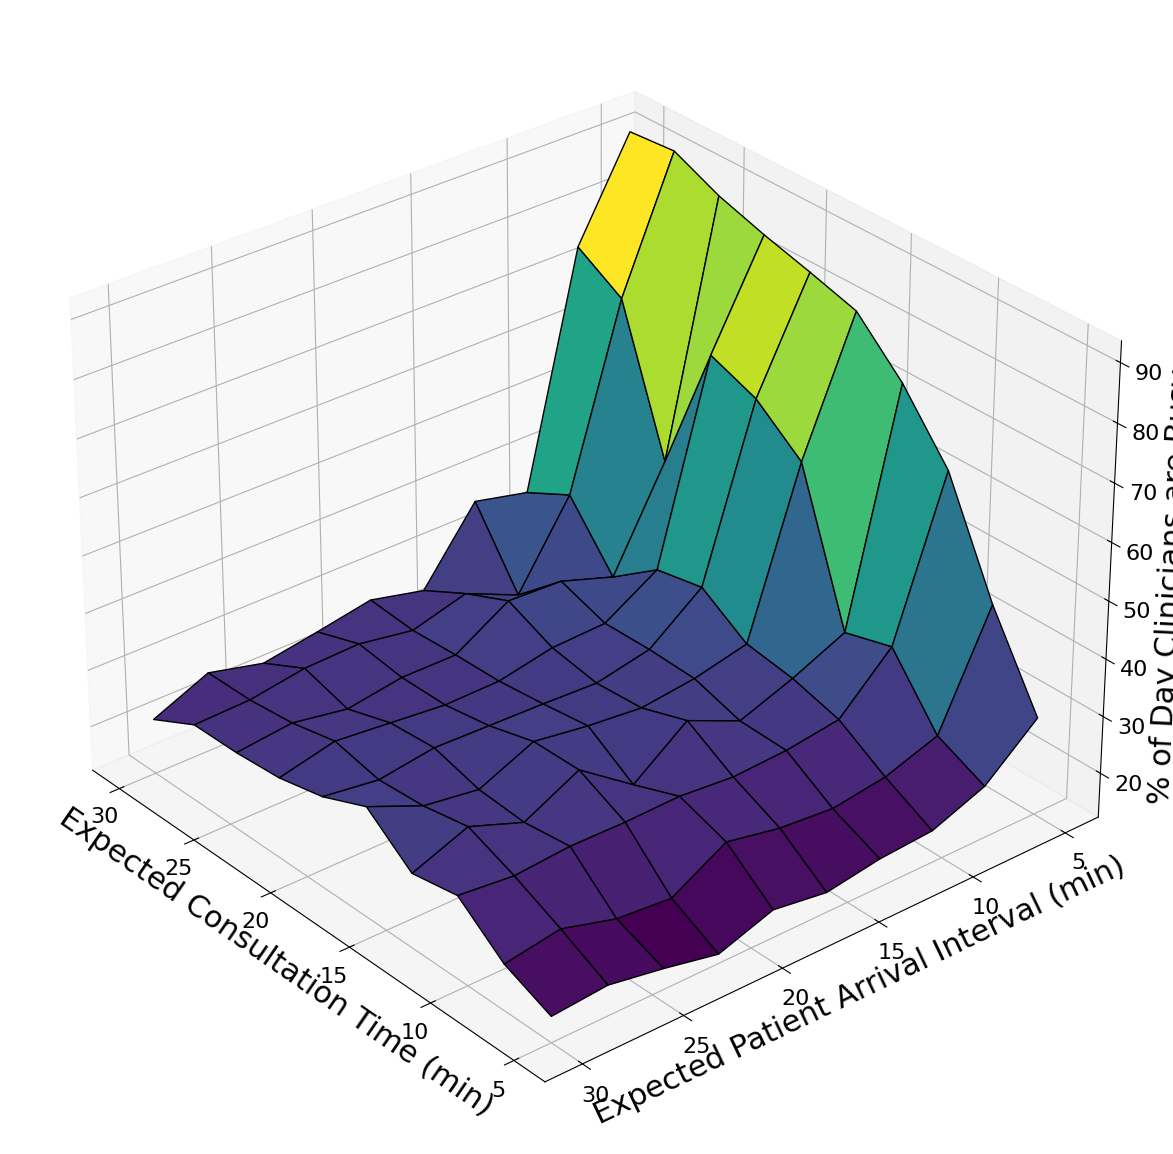

In [110]:
# average wait time (surface plot)
X, Y = np.meshgrid(service_rates, arrival_rates)

median_clin_up = (np.median(clin_up, axis=2)/sim_duration)*100

# Plot surface
fig = plt.figure(figsize=(12, 18))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, median_clin_up, cmap='viridis', edgecolor='k')
ax.view_init(elev=30, azim=140)
ax.dist = 50

ax.set_xlabel("Expected Consultation Time (min)", fontdict={'fontsize':font_size})
ax.set_ylabel("Expected Patient Arrival Interval (min)", fontdict={'fontsize':font_size})
ax.set_zlabel(r"% of Day Clinicians are Busy", fontdict={'fontsize':font_size})

# ax.xaxis.labelpad = label_padding  
# ax.yaxis.labelpad = label_padding  
# ax.zaxis.labelpad = label_padding

pos = ax.get_position()  # Get current plot position
ax.set_position([pos.x0 - 1, pos.y0, pos.width, pos.height])  # Shift left


ax.tick_params(axis="both", labelsize=tick_size)

plt.tight_layout()
plt.subplots_adjust(left=0.005, right=0.95) 
plt.show()


In [111]:
# repeat with no lunch rush
# whether we want to model the lunch rush
lunch_rush = False

# Create parameter sweep
n_intvl = 10
arrival_rates = np.linspace(5,30,n_intvl) # i
service_rates = np.linspace(5,30,n_intvl) # j
sim_duration = 60*8
# print(arrival_rates)

# want to repeat to get confidence intervals
n_rep = 20 # r

simulation_results = np.empty((n_intvl, n_intvl, n_rep), dtype=object)

# loop to create simulation class objects
for i in range(n_intvl):
    for j in range(n_intvl):
        for r in range(n_rep):
            env = simpy.Environment()
            #initialise simulation class object
            HealthCareSim = HealthCareService_c(env, 4)
            HealthCareSim.define_param(mu_walkin=arrival_rates[i], mu_service=service_rates[j],duration=sim_duration)

            # clear data from last run
            HealthCareSim.reset()

            #run simulation
            env.process(HealthCareService(HealthCareSim.env, HealthCareSim, lunch_rush))
            env.run(until=HealthCareSim.duration)
            # save all results
            simulation_results[i, j, r] = HealthCareSim

# print(simulation_results[0:4,:,:])

In [112]:
# KPIs
# average wait time
# number of patients seen
# clinician up time
# number of patients wait > 60 mins

avg_wait = num_patients = clin_up = wait_60 = np.zeros((n_intvl, n_intvl, n_rep))

for i in range(n_intvl):
    for j in range(n_intvl):
        for r in range(n_rep):
            patient_waits = [patient.wait_time for patient in simulation_results[i, j, r].patients_list]
            avg_wait[i,j,r] = np.mean(patient_waits)
            wait_60[i,j,r] = sum(x > 60 for x in patient_waits)

            num_patients[i, j, r] = len(patient_waits)

            clin_up[i, j, r] = simulation_results[i, j, r].usage_time

(10, 10)
[[110.23815496 128.64044921 153.17719929 229.17731975 271.99982456
  362.62200933 417.85096537 417.25060881 436.33356842 446.76282619]
 [ 83.93830122 118.18598964 124.00632254 152.67827115 140.05729175
  156.96799527 181.80308936 236.24330843 178.02123699 193.46135568]
 [ 76.53225126 122.86889051 135.27935061 133.877978   128.3046606
  132.97682111 135.83465475 144.41852885 148.90293119 150.91411467]]


/tmp/ipykernel_452334/22878450.py:30: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


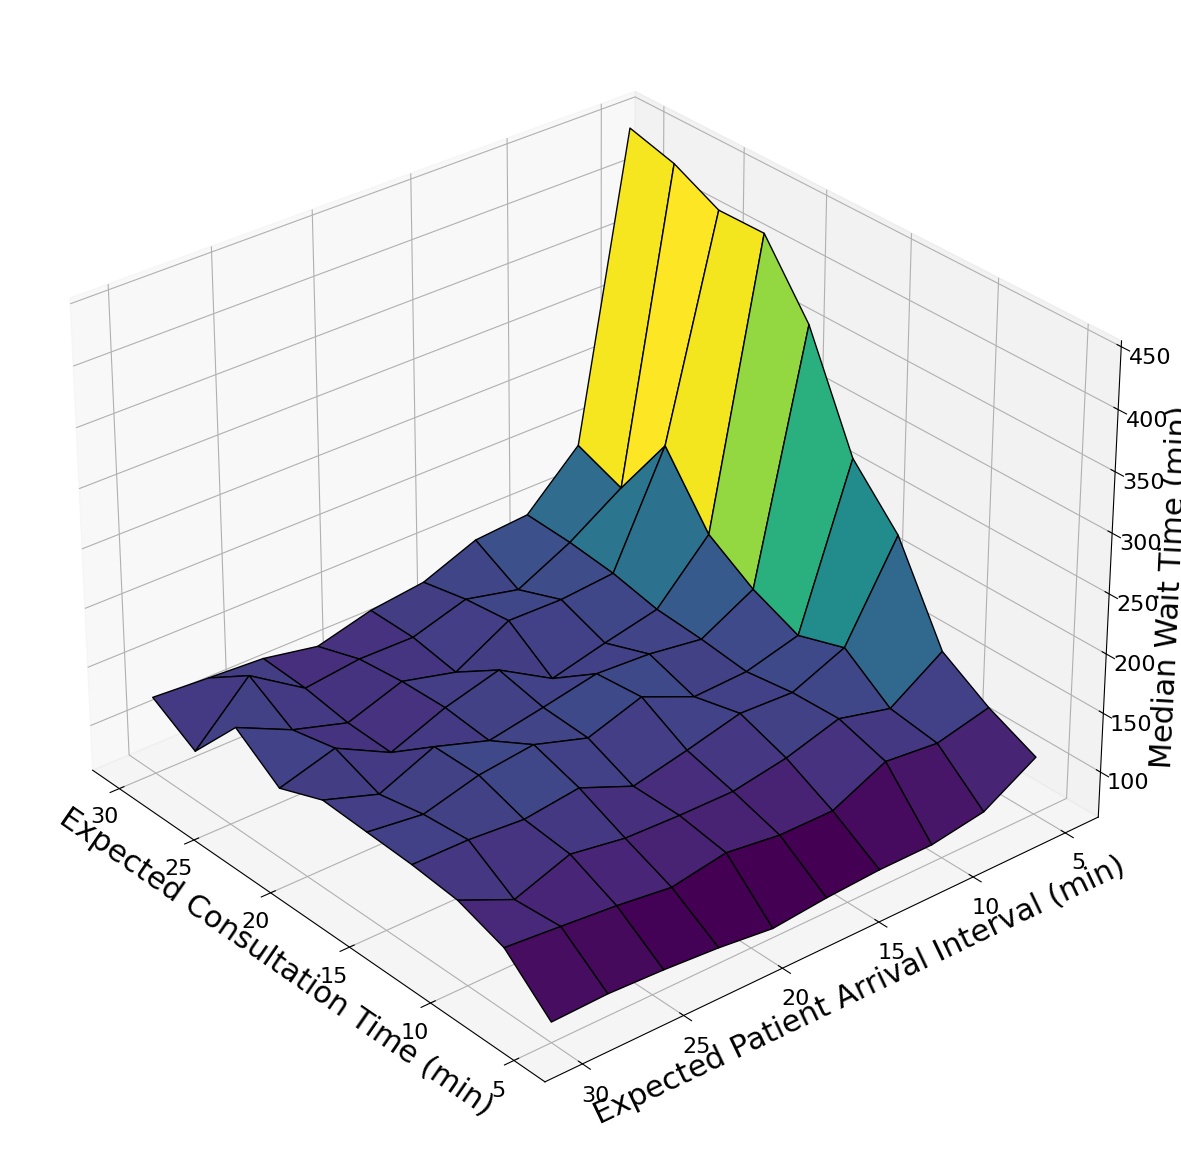

In [ ]:
# average wait time (surface plot)
X, Y = np.meshgrid(service_rates, arrival_rates)

median_avg_wait = np.median(avg_wait, axis=2)
print(np.shape(median_avg_wait))
print(median_avg_wait[0:3])

# Plot surface
fig = plt.figure(figsize=(12, 16))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, median_avg_wait, cmap='viridis', edgecolor='k')
ax.view_init(elev=30, azim=140)
ax.dist = 50

ax.set_xlabel("Expected Consultation Time (min)", fontdict={'fontsize':font_size})
ax.set_ylabel("Expected Patient Arrival Interval (min)", fontdict={'fontsize':font_size})
ax.set_zlabel("Median Wait Time (min)", fontdict={'fontsize':font_size})

# ax.xaxis.labelpad = label_padding  
# ax.yaxis.labelpad = label_padding  
# ax.zaxis.labelpad = label_padding

pos = ax.get_position()  # Get current plot position
ax.set_position([pos.x0 - 1, pos.y0, pos.width, pos.height])  # Shift left


ax.tick_params(axis="both", labelsize=tick_size)

plt.tight_layout()
plt.subplots_adjust(left=0.005, right=0.95) 
plt.show()
